In [ ]:
import pandas as pd
import numpy as np
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score



In [ ]:
train_df = pd.read_csv("train_clean.csv")


In [ ]:
tabular_features = [
    'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
    'floors', 'waterfront', 'view', 'condition', 'grade'
]

y = train_df['price'].values


In [ ]:
resnet = models.resnet18(pretrained=True)
resnet.eval()

resnet_embedding = torch.nn.Sequential(
    *list(resnet.children())[:-1]
)

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 162MB/s]


In [ ]:
import os
print(os.getcwd())
print(os.listdir())


/content
['.config', 'drive', 'test_clean.csv', 'train_clean.csv', 'new_train_zip.zip', '.ipynb_checkpoints', 'sample_data']


In [ ]:
!file "images_train (1).zip"
!unzip -t "images_train (1).zip"


images_train (1).zip: Zip archive data, at least v1.0 to extract, compression method=store
Archive:  images_train (1).zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of images_train (1).zip or
        images_train (1).zip.zip, and cannot find images_train (1).zip.ZIP, period.


In [ ]:
import zipfile
import os

os.makedirs("/content/new_images_arka", exist_ok=True)

with zipfile.ZipFile("new_train_zip.zip", "r") as zip_ref:
    zip_ref.extractall("/content/new_images_arka")


In [ ]:
!pip install catboost



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.5 MB/s eta 0:00:00


In [65]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

emb_dict = {}

image_dir = "/content/new_images_arka"

for root, dirs, files in os.walk(image_dir):
    for f in files:
        if f.lower().endswith((".png", ".jpg", ".jpeg")):
            img_id = f.split(".")[0]
            img_path = os.path.join(root, f)

            img = load_img(img_path, target_size=(128, 128))
            x = img_to_array(img)
            x = np.expand_dims(x, axis=0)
            x = preprocess_input(x)

            emb = mob_model.predict(x, verbose=0)
            emb_dict[img_id] = emb.flatten()

print("Embeddings created:", len(emb_dict))


Embeddings created: 4994


In [68]:
X_tab_list = []
X_img_list = []
y_list = []
ids = train_df["id"].astype(str).values

for i, img_id in enumerate(ids):
    if img_id in emb_dict:
        X_tab_list.append(X_tab[i])
        X_img_list.append(emb_dict[img_id])
        y_list.append(y[i])

X_tab_final = np.array(X_tab_list)
X_img_final = np.array(X_img_list)
y_final = np.array(y_list)

print(X_tab_final.shape, X_img_final.shape, y_final.shape)


(5000, 9) (5000, 1280) (5000,)


In [69]:
print("Images found:", len(emb_dict))
print("Matched rows:", len(y_final))
print("Original rows:", len(train_df))


Images found: 4994
Matched rows: 5000
Original rows: 5000


In [70]:
X_combined = np.hstack([X_tab_final, X_img_final])
print("Final feature shape:", X_combined.shape)


Final feature shape: (5000, 1289)


In [85]:
from sklearn.model_selection import train_test_split

X_val, X_train, y_val, y_train = train_test_split(
    X_combined,
    y_final,
    test_size=0.2,
    random_state=42
)


In [72]:
from catboost import CatBoostRegressor

model = CatBoostRegressor(
    iterations=600,
    depth=8,
    learning_rate=0.04,
    loss_function="RMSE",
    random_seed=42,
    verbose=100
)

model.fit(X_train, y_train)


0:	learn: 368468.7336309	total: 4.44s	remaining: 44m 18s
100:	learn: 186652.6724673	total: 2m 6s	remaining: 10m 24s
200:	learn: 148751.8013878	total: 4m 1s	remaining: 7m 58s
300:	learn: 122219.9649124	total: 5m 51s	remaining: 5m 49s
400:	learn: 100019.7553595	total: 7m 42s	remaining: 3m 49s
500:	learn: 80255.4602980	total: 9m 34s	remaining: 1m 53s
599:	learn: 65335.9696294	total: 11m 26s	remaining: 0us


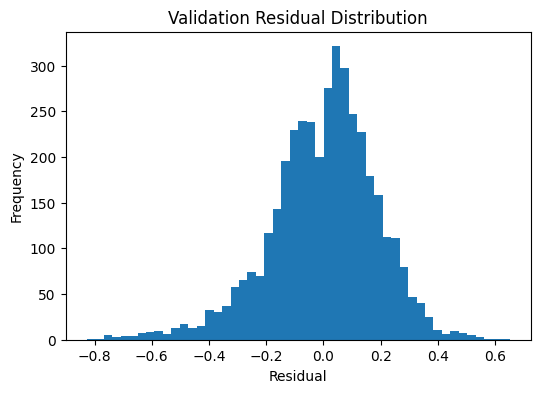

        split          rmse        r2  pearson_corr  spearman_corr
0  validation  65335.969629  0.969479      0.986357       0.960847
Evaluation time (s): 7.159


In [90]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import pearsonr, spearmanr

start_time = time.time()

# Predictions
val_preds = model.predict(X_val).reshape(-1, 1)
y_val_arr = np.array(y_val).reshape(-1, 1)

# Scaling (fit ONLY on validation)
scaler = StandardScaler()
val_preds_scaled = scaler.fit_transform(val_preds)
y_val_scaled = scaler.transform(y_val_arr)

# Residuals
val_diff = val_preds_scaled - y_val_scaled

# Metrics
val_rmse = np.sqrt(mean_squared_error(y_val_arr, val_preds))
val_r2 = r2_score(y_val_arr, val_preds)
val_corr_p = pearsonr(y_val_arr.flatten(), val_preds.flatten())[0]
val_corr_s = spearmanr(y_val_arr.flatten(), val_preds.flatten())[0]

# PCA (optional, now correct)
pca = PCA(n_components=1)
val_pca = pca.fit_transform(val_preds_scaled)

# Metrics table
metrics_df = pd.DataFrame({
    "split": ["validation"],
    "rmse": [val_rmse],
    "r2": [val_r2],
    "pearson_corr": [val_corr_p],
    "spearman_corr": [val_corr_s]
})

# Plot
plt.figure(figsize=(6,4))
plt.hist(val_diff.flatten(), bins=50)
plt.title("Validation Residual Distribution")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()

elapsed = time.time() - start_time

print(metrics_df)
print("Evaluation time (s):", round(elapsed, 3))


In [83]:
print("Validation RMSE:", val_rmse)
print("Validation R2:", val_r2)


Validation RMSE: 65335.96962938096
Validation R2: 0.9694793648029322


In [ ]:
test_df = pd.read_excel("test2.xlsx")

In [92]:
import zipfile
import os

os.makedirs("arka_test", exist_ok=True)

with zipfile.ZipFile("images_test_new.zip", "r") as zip_ref:
    zip_ref.extractall("arka_test")


In [93]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from catboost import CatBoostRegressor

test_csv_path = "test_clean.csv"
test_image_dir = "arka_test"


In [94]:
test_df = pd.read_csv(test_csv_path)
tabular_features = [col for col in test_df.columns if col != "price"]  # adjust if 'price' exists
X_test_tab = test_df[tabular_features].head(500).values  # use only 500 rows
test_ids = test_df['id'].head(500).astype(str).tolist()





In [95]:
mob_model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg')


/tmp/ipython-input-1559270374.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mob_model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg')


In [96]:
emb_dict_test = {}
image_files = []

for root, dirs, files in os.walk(test_image_dir):
    for f in files:
        if f.lower().endswith((".png", ".jpg", ".jpeg")):
            img_id = f.split(".")[0]
            img_path = os.path.join(root, f)
            if os.path.isfile(img_path):
                image_files.append((img_id, img_path))

for img_id, img_path in image_files:
    if img_id in test_ids:  # only process top 500
        img = load_img(img_path, target_size=(128, 128))
        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        emb = mob_model.predict(x, verbose=0)
        emb_dict_test[img_id] = emb.flatten()


In [99]:
import numpy as np

# Select only numeric columns for tabular features
tabular_features = test_df.select_dtypes(include=[np.number]).columns.tolist()
if 'price' in tabular_features:
    tabular_features.remove('price')

X_test_img_list = []
X_test_tab_list = []
final_ids = []

for i, row in test_df.head(500).iterrows():
    img_id = str(row["id"])
    if img_id in emb_dict_test:
        X_test_tab_list.append(row[tabular_features].values.astype(float))
        X_test_img_list.append(emb_dict_test[img_id])
        final_ids.append(img_id)

# Convert to numpy arrays
X_test_tab_aligned = np.array(X_test_tab_list)
X_test_img_aligned = np.array(X_test_img_list)

# Combine tabular + image embeddings
X_test_combined = np.hstack([X_test_tab_aligned, X_test_img_aligned])

print("Test combined shape:", X_test_combined.shape)
print("Number of test IDs aligned:", len(final_ids))


Test combined shape: (500, 1299)
Number of test IDs aligned: 500


In [100]:
import pandas as pd


y_test_pred_log = model.predict(X_test_combined)
y_test_pred = np.expm1(y_test_pred_log)


final_df = pd.DataFrame({
    "id": final_ids,
    "predicted_price": y_test_pred
})

final_df.to_csv("enrollno_final.csv", index=False)

print("Predictions saved to enrollno_final.csv")
print(final_df.head())


Predictions saved to enrollno_final.csv
           id  predicted_price
0  2591820310              inf
1  7974200820              inf
2  7701450110              inf
3  9522300010              inf
4  9510861140              inf


/tmp/ipython-input-524218846.py:5: RuntimeWarning: overflow encountered in expm1
  y_test_pred = np.expm1(y_test_pred_log)           # convert back to original scale


In [101]:
submission_df = pd.DataFrame({
    "id": final_ids,
    "predicted_price": y_test_pred
})

submission_df.to_csv("enrollno_final.csv", index=False)
print("Prediction file saved as enrollno_final.csv")


Prediction file saved as enrollno_final.csv
